In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.utils.data as Data
from torchvision import datasets
from torchvision.io import read_image
import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

# On crée la classe de Dataset

class ImageDataset(Data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None,test=False):
        self.test=test
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.img_files=os.listdir(img_dir)
        self.transform1 = transforms.Compose([ #Transformations communes aux tests et train 
            transforms.ToPILImage(),
            transforms.CenterCrop(size=256),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize(0.5,0.5),
        ])
        self.transform2 = transforms.Compose([ #Transformations seulement pour le train, pour limiter l'overfitting
            transforms.RandomRotation(degrees=(0,180)),
            transforms.RandomHorizontalFlip(p=0.3),
            transforms.RandomVerticalFlip(p=0.3),
        ])
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        if not self.test:
            img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0])+'.jpg')
            image = read_image(img_path)
            label = self.img_labels.iloc[idx, 1]-1
            if self.transform1:#On applique les 2 transformations
                image = self.transform1(image)
                image = self.transform2(image)

            if self.target_transform:
                label = self.target_transform(label)
            return image, label
        else:
            img_path = os.path.join(self.img_dir, f'{4000 + idx}.jpg')
            image = read_image(img_path)
            if self.transform1: #On applique 1 seule transformation
                image = self.transform1(image)
            return image



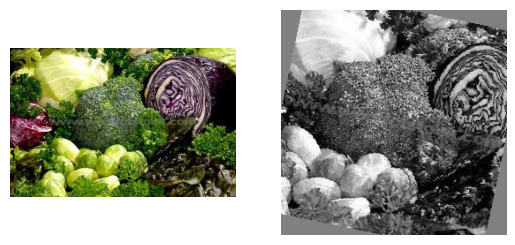

In [2]:
orig_img = Image.open(Path('train/train') / '7.jpg')
plt.subplot(1,2,1)
plt.imshow(orig_img,cmap='gray')  
plt.axis('off')   #Image originale

plt.subplot(1,2,2)
df=ImageDataset("train.csv","train/train")
plt.imshow(df.__getitem__(7)[0][0],cmap='gray')  
plt.axis('off')  
plt.show() #Même image mais dans le dataset

In [3]:
import torch.nn as nn

class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            #nn.Dropout(0.2), #certains dropout sont mis en commentaires pour éviter qu'il y ait trop de régularisations
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            #nn.Dropout(0.2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16 * 61 * 61, 120),
            #nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        return self.network(x)
    

In [4]:
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

#On crée les dataset de train et de test 
train_dataset =Data.Subset(df, range(train_size))
test_dataset = Data.Subset(df, range(train_size, train_size + test_size))

trainloader = Data.DataLoader(train_dataset, batch_size=128, shuffle=True)
testloader = Data.DataLoader(test_dataset, batch_size=128, shuffle=False)


In [16]:
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score


device = torch.device('cuda')

num_epochs = 50
model = LeNet(num_classes=4)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3,momentum=0.9)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    all_preds = []
    all_labels=[]
    model.train()
    for i, batch in enumerate(tqdm(trainloader,desc=f'Epoch {epoch+1}/{num_epochs}')):
        inputs, label = batch
        inputs, label = inputs.to(device).float(), label.to(device)

        #Apprentissage 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, label)

        running_loss += loss.item()
        #Calcul de l'accuracy
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())
        loss.backward()
        optimizer.step()

    # Stockez la perte d'entraînement moyenne à cette époque
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(accuracy_score(all_labels, all_preds))

    # Calculez la perte de test à cette époque
    running_loss = 0.0
    all_preds = []
    all_labels=[]
    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(testloader):
            inputs, label = batch
            inputs, label = inputs.to(device).float(), label.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, label)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    # Stockez la perte de test moyenne à cette époque
    test_losses.append(running_loss / len(testloader))
    test_accuracies.append(accuracy_score(all_labels, all_preds))
print('Entraînement terminé')


Epoch 50/50: 100%|██████████| 25/25 [00:07<00:00,  3.48it/s]


Entraînement terminé


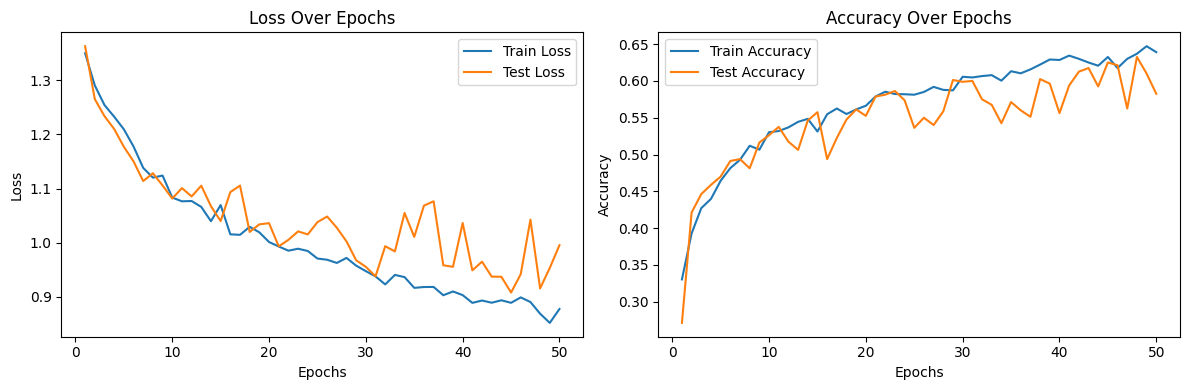

Accuracy finale : 0.5825


In [17]:
#Affichage des résultats
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()
print(f"Accuracy finale : {test_accuracies[-1]}")



Epoch 1/50: 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]


Accuracy de train : 0.2975
Accuracy de test : 0.35
Loss de train : 2.492266502380371
Loss de test : 1.3960513387407576


Epoch 2/50: 100%|██████████| 25/25 [00:06<00:00,  4.13it/s]


Accuracy de train : 0.359375
Accuracy de test : 0.36625
Loss de train : 1.3258851146697999
Loss de test : 1.3191330092293876


Epoch 3/50: 100%|██████████| 25/25 [00:07<00:00,  3.40it/s]


Accuracy de train : 0.409375
Accuracy de test : 0.3925
Loss de train : 1.2781319332122802
Loss de test : 1.2901685237884521


Epoch 4/50: 100%|██████████| 25/25 [00:06<00:00,  3.72it/s]


Accuracy de train : 0.419375
Accuracy de test : 0.385
Loss de train : 1.2561480569839478
Loss de test : 1.3010364770889282


Epoch 5/50: 100%|██████████| 25/25 [00:07<00:00,  3.43it/s]


Accuracy de train : 0.428125
Accuracy de test : 0.41125
Loss de train : 1.241201138496399
Loss de test : 1.2840136459895544


Epoch 6/50: 100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Accuracy de train : 0.4284375
Accuracy de test : 0.43125
Loss de train : 1.2523793411254882
Loss de test : 1.2335408074515206


Epoch 7/50: 100%|██████████| 25/25 [00:06<00:00,  3.69it/s]


Accuracy de train : 0.43625
Accuracy de test : 0.45625
Loss de train : 1.2138510465621948
Loss de test : 1.2052913052695138


Epoch 8/50: 100%|██████████| 25/25 [00:06<00:00,  3.60it/s]


Accuracy de train : 0.4715625
Accuracy de test : 0.43125
Loss de train : 1.18732412815094
Loss de test : 1.2219445875712804


Epoch 9/50: 100%|██████████| 25/25 [00:07<00:00,  3.37it/s]


Accuracy de train : 0.4728125
Accuracy de test : 0.44
Loss de train : 1.1845695066452027
Loss de test : 1.2425028085708618


Epoch 10/50: 100%|██████████| 25/25 [00:07<00:00,  3.22it/s]


Accuracy de train : 0.4871875
Accuracy de test : 0.45125
Loss de train : 1.1605282592773438
Loss de test : 1.174674732344491


Epoch 11/50: 100%|██████████| 25/25 [00:07<00:00,  3.22it/s]


Accuracy de train : 0.50625
Accuracy de test : 0.4675
Loss de train : 1.1103131246566773
Loss de test : 1.1740073306219918


Epoch 12/50: 100%|██████████| 25/25 [00:07<00:00,  3.14it/s]


Accuracy de train : 0.4971875
Accuracy de test : 0.4875
Loss de train : 1.1215621042251587
Loss de test : 1.1448722907475062


Epoch 13/50: 100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Accuracy de train : 0.5134375
Accuracy de test : 0.52875
Loss de train : 1.0937279486656188
Loss de test : 1.0873889071600777


Epoch 14/50: 100%|██████████| 25/25 [00:06<00:00,  3.58it/s]


Accuracy de train : 0.5225
Accuracy de test : 0.5175
Loss de train : 1.0717022514343262
Loss de test : 1.0814393843923296


Epoch 15/50: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s]


Accuracy de train : 0.5365625
Accuracy de test : 0.5275
Loss de train : 1.0533910918235778
Loss de test : 1.0222556250435966


Epoch 16/50: 100%|██████████| 25/25 [00:06<00:00,  3.60it/s]


Accuracy de train : 0.5396875
Accuracy de test : 0.57125
Loss de train : 1.0590600347518921
Loss de test : 1.0350767033440726


Epoch 17/50: 100%|██████████| 25/25 [00:06<00:00,  3.60it/s]


Accuracy de train : 0.5390625
Accuracy de test : 0.525
Loss de train : 1.0414349961280822
Loss de test : 1.096556237765721


Epoch 18/50: 100%|██████████| 25/25 [00:07<00:00,  3.41it/s]


Accuracy de train : 0.555625
Accuracy de test : 0.52875
Loss de train : 1.0163442158699036
Loss de test : 1.0684384277888708


Epoch 19/50: 100%|██████████| 25/25 [00:07<00:00,  3.52it/s]


Accuracy de train : 0.561875
Accuracy de test : 0.55
Loss de train : 1.0006003499031066
Loss de test : 1.0374103103365218


Epoch 20/50: 100%|██████████| 25/25 [00:07<00:00,  3.45it/s]


Accuracy de train : 0.56
Accuracy de test : 0.5725
Loss de train : 1.0012321615219115
Loss de test : 1.0355438590049744


Epoch 21/50: 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]


Accuracy de train : 0.589375
Accuracy de test : 0.57
Loss de train : 0.9726805853843689
Loss de test : 1.0000628573553902


Epoch 22/50: 100%|██████████| 25/25 [00:07<00:00,  3.41it/s]


Accuracy de train : 0.5853125
Accuracy de test : 0.575
Loss de train : 0.9749041056632995
Loss de test : 1.0096038665090288


Epoch 23/50: 100%|██████████| 25/25 [00:07<00:00,  3.39it/s]


Accuracy de train : 0.5896875
Accuracy de test : 0.60625
Loss de train : 0.9567150449752808
Loss de test : 0.9815189753259931


Epoch 24/50: 100%|██████████| 25/25 [00:06<00:00,  3.72it/s]


Accuracy de train : 0.6065625
Accuracy de test : 0.58875
Loss de train : 0.9519701313972473
Loss de test : 0.9641024044581822


Epoch 25/50: 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]


Accuracy de train : 0.5884375
Accuracy de test : 0.58625
Loss de train : 0.9540609407424927
Loss de test : 0.9742483837263924


Epoch 26/50: 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]


Accuracy de train : 0.5840625
Accuracy de test : 0.5675
Loss de train : 0.9635587692260742
Loss de test : 1.0091440847941808


Epoch 27/50: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


Accuracy de train : 0.6090625
Accuracy de test : 0.58375
Loss de train : 0.9310357594490051
Loss de test : 0.9844908288546971


Epoch 28/50: 100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Accuracy de train : 0.615
Accuracy de test : 0.5825
Loss de train : 0.9023543691635132
Loss de test : 0.9698942729404995


Epoch 29/50: 100%|██████████| 25/25 [00:07<00:00,  3.57it/s]


Accuracy de train : 0.613125
Accuracy de test : 0.5975
Loss de train : 0.9181713008880615
Loss de test : 0.9568006481443133


Epoch 30/50: 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]


Accuracy de train : 0.615
Accuracy de test : 0.57
Loss de train : 0.9085432600975036
Loss de test : 1.0230927552495683


Epoch 31/50: 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]


Accuracy de train : 0.6259375
Accuracy de test : 0.60875
Loss de train : 0.8959242558479309
Loss de test : 0.9120802709034511


Epoch 32/50: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.6371875
Accuracy de test : 0.61
Loss de train : 0.8708060145378113
Loss de test : 0.9313242094857352


Epoch 33/50: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.6353125
Accuracy de test : 0.6125
Loss de train : 0.8740796875953675
Loss de test : 0.9270066789218357


Epoch 34/50: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.61875
Accuracy de test : 0.59375
Loss de train : 0.9000551676750184
Loss de test : 0.9655682189123971


Epoch 35/50: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.6415625
Accuracy de test : 0.63
Loss de train : 0.8642384910583496
Loss de test : 0.9388946379934039


Epoch 36/50: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.640625
Accuracy de test : 0.62375
Loss de train : 0.8694019412994385
Loss de test : 0.9268964103290013


Epoch 37/50: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.6346875
Accuracy de test : 0.615
Loss de train : 0.8764771747589112
Loss de test : 0.9562586801392692


Epoch 38/50: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.6390625
Accuracy de test : 0.6225
Loss de train : 0.8476753044128418
Loss de test : 0.9793530447142464


Epoch 39/50: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.64375
Accuracy de test : 0.64375
Loss de train : 0.86591956615448
Loss de test : 0.9006950684956142


Epoch 40/50: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.6425
Accuracy de test : 0.645
Loss de train : 0.8731857705116272
Loss de test : 0.891728971685682


Epoch 41/50: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.656875
Accuracy de test : 0.61875
Loss de train : 0.8465178036689758
Loss de test : 0.9175633788108826


Epoch 42/50: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.66
Accuracy de test : 0.64
Loss de train : 0.8279193496704101
Loss de test : 0.8827645948954991


Epoch 43/50: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.6615625
Accuracy de test : 0.64375
Loss de train : 0.8223668670654297
Loss de test : 0.8982919028827122


Epoch 44/50: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.664375
Accuracy de test : 0.63625
Loss de train : 0.8254271340370178
Loss de test : 0.9014056324958801


Epoch 45/50: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.679375
Accuracy de test : 0.6425
Loss de train : 0.7970920443534851
Loss de test : 0.9230458736419678


Epoch 46/50: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.6734375
Accuracy de test : 0.63875
Loss de train : 0.8180904150009155
Loss de test : 0.8899767739432198


Epoch 47/50: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.6628125
Accuracy de test : 0.6525
Loss de train : 0.8088827490806579
Loss de test : 0.8901746698788234


Epoch 48/50: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.6625
Accuracy de test : 0.645
Loss de train : 0.8148924088478089
Loss de test : 0.9027935096195766


Epoch 49/50: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.6796875
Accuracy de test : 0.65625
Loss de train : 0.8047381472587586
Loss de test : 0.8794986605644226


Epoch 50/50: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.673125
Accuracy de test : 0.62625
Loss de train : 0.791895124912262
Loss de test : 0.9171877758843558
Entraînement terminé


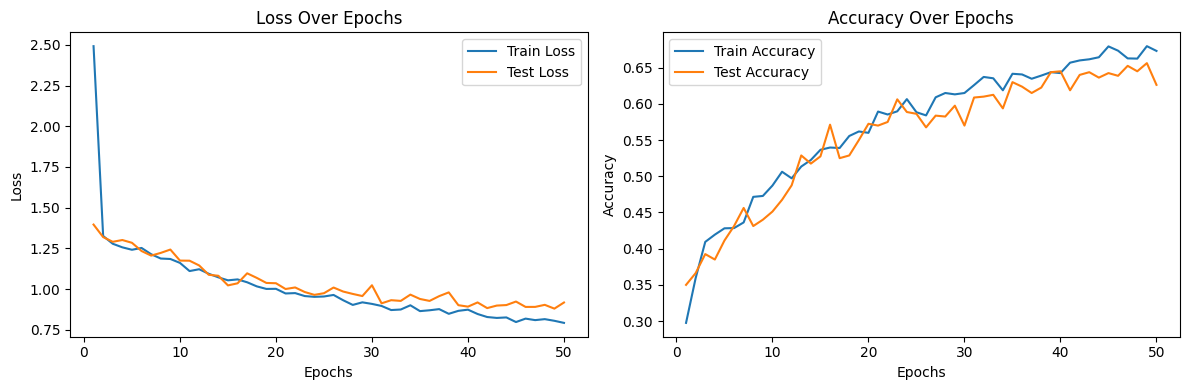

Accuracy finale : 0.62625


In [7]:
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score

#Apprentissage avec Adam
device = torch.device('cuda')

num_epochs = 50
model = LeNet(num_classes=4)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3) #optimizer différents

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    all_preds = []
    all_labels=[]
    for i, batch in enumerate(tqdm(trainloader,desc=f'Epoch {epoch+1}/{num_epochs}')):
        inputs, label = batch
        inputs, label = inputs.to(device).float(), label.to(device)

        #Apprentissage
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, label)

        running_loss += loss.item()
        #Calcul de l'accuracy
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())
        loss.backward()
        optimizer.step()

    # Stockez la perte d'entraînement moyenne à cette époque
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(accuracy_score(all_labels, all_preds))

    # Calculez la perte de test à cette époque
    running_loss = 0.0
    all_preds = []
    all_labels=[]
    model.train()
    with torch.no_grad():
        for i, batch in enumerate(testloader):
            inputs, label = batch
            inputs, label = inputs.to(device).float(), label.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, label)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    # Stockez la perte de test moyenne à cette époque
    test_losses.append(running_loss / len(testloader))
    test_accuracies.append(accuracy_score(all_labels, all_preds))
    print(f"Accuracy de train : {train_accuracies[-1]}")
    print(f"Accuracy de test : {test_accuracies[-1]}")
    print(f"Loss de train : {train_losses[-1]}")
    print(f"Loss de test : {test_losses[-1]}")
print('Entraînement terminé')


#Affichage des résultats
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()


print(f"Accuracy finale : {test_accuracies[-1]}")

Epoch 1/100:   0%|          | 0/25 [00:00<?, ?it/s]/home/tristan/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 1/100: 100%|██████████| 25/25 [00:08<00:00,  2.79it/s]
/home/tristan/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Accuracy de train : 0.291875
Accuracy de test : 0.31125
Loss de train : 2.683090720176697
Loss de test : 1.4072567224502563


Epoch 2/100: 100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Accuracy de train : 0.3434375
Accuracy de test : 0.37375
Loss de train : 1.3457193183898926
Loss de test : 1.3025162730898177


Epoch 3/100: 100%|██████████| 25/25 [00:06<00:00,  3.67it/s]


Accuracy de train : 0.3803125
Accuracy de test : 0.38375
Loss de train : 1.2977302932739259
Loss de test : 1.2883180039269584


Epoch 4/100: 100%|██████████| 25/25 [00:05<00:00,  4.25it/s]


Accuracy de train : 0.4009375
Accuracy de test : 0.39625
Loss de train : 1.2762086296081543
Loss de test : 1.2740592445646013


Epoch 5/100: 100%|██████████| 25/25 [00:06<00:00,  3.59it/s]


Accuracy de train : 0.3940625
Accuracy de test : 0.43875
Loss de train : 1.2586060237884522
Loss de test : 1.2629702602113997


Epoch 6/100: 100%|██████████| 25/25 [00:06<00:00,  3.80it/s]


Accuracy de train : 0.4328125
Accuracy de test : 0.41125
Loss de train : 1.2387934684753419
Loss de test : 1.268768412726266


Epoch 7/100: 100%|██████████| 25/25 [00:06<00:00,  3.57it/s]


Accuracy de train : 0.436875
Accuracy de test : 0.44125
Loss de train : 1.2322766876220703
Loss de test : 1.2329961912972587


Epoch 8/100: 100%|██████████| 25/25 [00:07<00:00,  3.47it/s]


Accuracy de train : 0.441875
Accuracy de test : 0.43375
Loss de train : 1.2118380784988403
Loss de test : 1.2169873544148035


Epoch 9/100: 100%|██████████| 25/25 [00:06<00:00,  3.69it/s]


Accuracy de train : 0.4559375
Accuracy de test : 0.45
Loss de train : 1.2039146041870117
Loss de test : 1.2068904978888375


Epoch 10/100: 100%|██████████| 25/25 [00:07<00:00,  3.35it/s]


Accuracy de train : 0.4996875
Accuracy de test : 0.4575
Loss de train : 1.1719487142562866
Loss de test : 1.2046798637935094


Epoch 11/100: 100%|██████████| 25/25 [00:06<00:00,  3.80it/s]


Accuracy de train : 0.4690625
Accuracy de test : 0.4625
Loss de train : 1.1831551790237427
Loss de test : 1.2114249297550745


Epoch 12/100: 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]


Accuracy de train : 0.47625
Accuracy de test : 0.5025
Loss de train : 1.153193745613098
Loss de test : 1.1754782710756575


Epoch 13/100: 100%|██████████| 25/25 [00:07<00:00,  3.43it/s]


Accuracy de train : 0.4984375
Accuracy de test : 0.49125
Loss de train : 1.1397147035598756
Loss de test : 1.1590115683419364


Epoch 14/100: 100%|██████████| 25/25 [00:07<00:00,  3.33it/s]


Accuracy de train : 0.51625
Accuracy de test : 0.49625
Loss de train : 1.1090549683570863
Loss de test : 1.1398296696799142


Epoch 15/100: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s]


Accuracy de train : 0.5265625
Accuracy de test : 0.52
Loss de train : 1.0990931820869445
Loss de test : 1.1058339732033866


Epoch 16/100: 100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Accuracy de train : 0.5328125
Accuracy de test : 0.4975
Loss de train : 1.0703362607955933
Loss de test : 1.1298558882304601


Epoch 17/100: 100%|██████████| 25/25 [00:07<00:00,  3.37it/s]


Accuracy de train : 0.53625
Accuracy de test : 0.50125
Loss de train : 1.0699937224388123
Loss de test : 1.1466267279216222


Epoch 18/100: 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]


Accuracy de train : 0.5428125
Accuracy de test : 0.525
Loss de train : 1.0614843225479127
Loss de test : 1.090922270502363


Epoch 19/100: 100%|██████████| 25/25 [00:07<00:00,  3.36it/s]


Accuracy de train : 0.546875
Accuracy de test : 0.55
Loss de train : 1.0615674948692322
Loss de test : 1.0762525626591273


Epoch 20/100: 100%|██████████| 25/25 [00:08<00:00,  3.08it/s]


Accuracy de train : 0.556875
Accuracy de test : 0.55
Loss de train : 1.0344842743873597
Loss de test : 1.0630452292306083


Epoch 21/100: 100%|██████████| 25/25 [00:07<00:00,  3.17it/s]


Accuracy de train : 0.5675
Accuracy de test : 0.52
Loss de train : 1.024492290019989
Loss de test : 1.1283530337469918


Epoch 22/100: 100%|██████████| 25/25 [00:08<00:00,  3.03it/s]


Accuracy de train : 0.5715625
Accuracy de test : 0.5325
Loss de train : 1.0284915614128112
Loss de test : 1.1315984385354179


Epoch 23/100: 100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


Accuracy de train : 0.555625
Accuracy de test : 0.54375
Loss de train : 1.0209007048606873
Loss de test : 1.0268736141068595


Epoch 24/100: 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


Accuracy de train : 0.584375
Accuracy de test : 0.5475
Loss de train : 0.9860079717636109
Loss de test : 1.0413483210972376


Epoch 25/100: 100%|██████████| 25/25 [00:08<00:00,  3.10it/s]


Accuracy de train : 0.5846875
Accuracy de test : 0.57125
Loss de train : 0.9796099019050598
Loss de test : 1.0743573989186967


Epoch 26/100: 100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Accuracy de train : 0.5828125
Accuracy de test : 0.58
Loss de train : 0.979728353023529
Loss de test : 0.9988458326884678


Epoch 27/100: 100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Accuracy de train : 0.595625
Accuracy de test : 0.56375
Loss de train : 0.9600703740119934
Loss de test : 1.0238242660249983


Epoch 28/100: 100%|██████████| 25/25 [00:09<00:00,  2.73it/s]


Accuracy de train : 0.5975
Accuracy de test : 0.55375
Loss de train : 0.9482869648933411
Loss de test : 1.0308263897895813


Epoch 29/100: 100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Accuracy de train : 0.5809375
Accuracy de test : 0.595
Loss de train : 0.9812239098548889
Loss de test : 0.9920509798186166


Epoch 30/100: 100%|██████████| 25/25 [00:08<00:00,  3.04it/s]


Accuracy de train : 0.598125
Accuracy de test : 0.58375
Loss de train : 0.9570302271842956
Loss de test : 0.992770288671766


Epoch 31/100: 100%|██████████| 25/25 [00:08<00:00,  2.78it/s]


Accuracy de train : 0.6059375
Accuracy de test : 0.5725
Loss de train : 0.9519943523406983
Loss de test : 1.0371753232819694


Epoch 32/100: 100%|██████████| 25/25 [00:07<00:00,  3.21it/s]


Accuracy de train : 0.6009375
Accuracy de test : 0.5875
Loss de train : 0.9611774635314941
Loss de test : 1.0170800515583582


Epoch 33/100: 100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Accuracy de train : 0.6228125
Accuracy de test : 0.59375
Loss de train : 0.9220192790031433
Loss de test : 0.9781321542603629


Epoch 34/100: 100%|██████████| 25/25 [00:07<00:00,  3.19it/s]


Accuracy de train : 0.6184375
Accuracy de test : 0.58375
Loss de train : 0.912576789855957
Loss de test : 0.9853618059839521


Epoch 35/100: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


Accuracy de train : 0.6096875
Accuracy de test : 0.59875
Loss de train : 0.9089775633811951
Loss de test : 0.9839543955666679


Epoch 36/100: 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]


Accuracy de train : 0.6234375
Accuracy de test : 0.5875
Loss de train : 0.9175086092948913
Loss de test : 1.0372426424707686


Epoch 37/100: 100%|██████████| 25/25 [00:08<00:00,  3.11it/s]


Accuracy de train : 0.6315625
Accuracy de test : 0.6125
Loss de train : 0.897637493610382
Loss de test : 0.9672313758305141


Epoch 38/100: 100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Accuracy de train : 0.6190625
Accuracy de test : 0.59375
Loss de train : 0.9251012706756592
Loss de test : 0.9865536093711853


Epoch 39/100: 100%|██████████| 25/25 [00:07<00:00,  3.39it/s]


Accuracy de train : 0.6328125
Accuracy de test : 0.6075
Loss de train : 0.8950674915313721
Loss de test : 0.9300253817013332


Epoch 40/100: 100%|██████████| 25/25 [00:07<00:00,  3.43it/s]


Accuracy de train : 0.6478125
Accuracy de test : 0.61875
Loss de train : 0.8715308022499084
Loss de test : 0.9259702478136335


Epoch 41/100: 100%|██████████| 25/25 [00:06<00:00,  3.95it/s]


Accuracy de train : 0.65
Accuracy de test : 0.62875
Loss de train : 0.861807107925415
Loss de test : 0.9379058565412249


Epoch 42/100: 100%|██████████| 25/25 [00:07<00:00,  3.48it/s]


Accuracy de train : 0.655
Accuracy de test : 0.63
Loss de train : 0.8596100425720214
Loss de test : 0.9422107594353812


Epoch 43/100: 100%|██████████| 25/25 [00:06<00:00,  3.63it/s]


Accuracy de train : 0.6378125
Accuracy de test : 0.59
Loss de train : 0.8767727398872376
Loss de test : 0.9943650450025286


Epoch 44/100: 100%|██████████| 25/25 [00:07<00:00,  3.57it/s]


Accuracy de train : 0.6409375
Accuracy de test : 0.6025
Loss de train : 0.8771064591407776
Loss de test : 0.9544549073491778


Epoch 45/100: 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]


Accuracy de train : 0.6534375
Accuracy de test : 0.6475
Loss de train : 0.8618234872817994
Loss de test : 0.9151644621576581


Epoch 46/100: 100%|██████████| 25/25 [00:07<00:00,  3.55it/s]


Accuracy de train : 0.648125
Accuracy de test : 0.6
Loss de train : 0.8571908402442933
Loss de test : 0.9480317320142474


Epoch 47/100: 100%|██████████| 25/25 [00:07<00:00,  3.17it/s]


Accuracy de train : 0.645625
Accuracy de test : 0.61875
Loss de train : 0.8760415697097779
Loss de test : 0.9251006415912083


Epoch 48/100: 100%|██████████| 25/25 [00:08<00:00,  3.00it/s]


Accuracy de train : 0.6646875
Accuracy de test : 0.63875
Loss de train : 0.8415468573570252
Loss de test : 0.9041903614997864


Epoch 49/100: 100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Accuracy de train : 0.6678125
Accuracy de test : 0.61
Loss de train : 0.8393666815757751
Loss de test : 0.9617148041725159


Epoch 50/100: 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


Accuracy de train : 0.65875
Accuracy de test : 0.63875
Loss de train : 0.8521727919578552
Loss de test : 0.8978225077901568


Epoch 51/100: 100%|██████████| 25/25 [00:08<00:00,  3.05it/s]


Accuracy de train : 0.656875
Accuracy de test : 0.60875
Loss de train : 0.8441051602363586
Loss de test : 0.9333574431283134


Epoch 52/100: 100%|██████████| 25/25 [00:07<00:00,  3.21it/s]


Accuracy de train : 0.6578125
Accuracy de test : 0.6025
Loss de train : 0.8441315078735352
Loss de test : 0.9975482395717076


Epoch 53/100: 100%|██████████| 25/25 [00:08<00:00,  3.12it/s]


Accuracy de train : 0.653125
Accuracy de test : 0.62125
Loss de train : 0.8479865527153015
Loss de test : 0.9856598802975246


Epoch 54/100: 100%|██████████| 25/25 [00:07<00:00,  3.21it/s]


Accuracy de train : 0.6684375
Accuracy de test : 0.60375
Loss de train : 0.8343507409095764
Loss de test : 0.9286003708839417


Epoch 55/100: 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]


Accuracy de train : 0.6659375
Accuracy de test : 0.62875
Loss de train : 0.8334689736366272
Loss de test : 0.9364326170512608


Epoch 56/100: 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]


Accuracy de train : 0.6521875
Accuracy de test : 0.62125
Loss de train : 0.8580709815025329
Loss de test : 0.9226547735077995


Epoch 57/100: 100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Accuracy de train : 0.660625
Accuracy de test : 0.63125
Loss de train : 0.8362093997001648
Loss de test : 0.961586764880589


Epoch 58/100: 100%|██████████| 25/25 [00:08<00:00,  3.00it/s]


Accuracy de train : 0.673125
Accuracy de test : 0.61375
Loss de train : 0.8185153985023499
Loss de test : 0.9957718423434666


Epoch 59/100: 100%|██████████| 25/25 [00:09<00:00,  2.62it/s]


Accuracy de train : 0.674375
Accuracy de test : 0.6325
Loss de train : 0.8211740112304687
Loss de test : 0.9416983212743487


Epoch 60/100: 100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Accuracy de train : 0.66625
Accuracy de test : 0.64
Loss de train : 0.8192020082473754
Loss de test : 0.8973985484668187


Epoch 61/100: 100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Accuracy de train : 0.6784375
Accuracy de test : 0.63375
Loss de train : 0.8064996409416199
Loss de test : 0.9186966504369464


Epoch 62/100: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]


Accuracy de train : 0.6709375
Accuracy de test : 0.6225
Loss de train : 0.8176826190948486
Loss de test : 0.9509671075003487


Epoch 63/100: 100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Accuracy de train : 0.6715625
Accuracy de test : 0.61875
Loss de train : 0.8176395368576049
Loss de test : 0.944373335157122


Epoch 64/100: 100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Accuracy de train : 0.675
Accuracy de test : 0.63125
Loss de train : 0.8092902708053589
Loss de test : 0.9157922267913818


Epoch 65/100: 100%|██████████| 25/25 [00:09<00:00,  2.74it/s]


Accuracy de train : 0.688125
Accuracy de test : 0.62375
Loss de train : 0.7913162279129028
Loss de test : 0.9257416299411229


Epoch 66/100: 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


Accuracy de train : 0.6953125
Accuracy de test : 0.63625
Loss de train : 0.7822514915466309
Loss de test : 0.8943001627922058


Epoch 67/100: 100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Accuracy de train : 0.6778125
Accuracy de test : 0.635
Loss de train : 0.8012057447433472
Loss de test : 0.8888683829988752


Epoch 68/100: 100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Accuracy de train : 0.676875
Accuracy de test : 0.63125
Loss de train : 0.8229073333740234
Loss de test : 0.9213605352810451


Epoch 69/100: 100%|██████████| 25/25 [00:07<00:00,  3.14it/s]


Accuracy de train : 0.684375
Accuracy de test : 0.635
Loss de train : 0.7902515816688538
Loss de test : 0.907367834023067


Epoch 70/100: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s]


Accuracy de train : 0.6759375
Accuracy de test : 0.63
Loss de train : 0.7903582906723022
Loss de test : 0.9567539436476571


Epoch 71/100: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.6784375
Accuracy de test : 0.64625
Loss de train : 0.7969391775131226
Loss de test : 0.9142445240701947


Epoch 72/100: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.6803125
Accuracy de test : 0.64875
Loss de train : 0.7943788814544678
Loss de test : 0.8725158146449498


Epoch 73/100: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.680625
Accuracy de test : 0.66
Loss de train : 0.798882155418396
Loss de test : 0.8705835257257734


Epoch 74/100: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.67625
Accuracy de test : 0.645
Loss de train : 0.8139471364021301
Loss de test : 0.9122743776866368


Epoch 75/100: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.686875
Accuracy de test : 0.65
Loss de train : 0.7804951429367065
Loss de test : 0.8687209742409843


Epoch 76/100: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.704375
Accuracy de test : 0.61
Loss de train : 0.7637023663520813
Loss de test : 0.9894261189869472


Epoch 77/100: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.675
Accuracy de test : 0.64375
Loss de train : 0.7978015708923339
Loss de test : 0.8932855469839913


Epoch 78/100: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.7059375
Accuracy de test : 0.6275
Loss de train : 0.7557140207290649
Loss de test : 0.9008193697248187


Epoch 79/100: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.6953125
Accuracy de test : 0.6475
Loss de train : 0.7639841794967651
Loss de test : 0.8559514795030866


Epoch 80/100: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.6775
Accuracy de test : 0.63875
Loss de train : 0.8008496379852295
Loss de test : 0.8906537549836295


Epoch 81/100: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.683125
Accuracy de test : 0.655
Loss de train : 0.7795028424263001
Loss de test : 0.8919691273144313


Epoch 82/100: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.6871875
Accuracy de test : 0.65375
Loss de train : 0.7916896319389344
Loss de test : 0.8705633793558393


Epoch 83/100: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.7015625
Accuracy de test : 0.63875
Loss de train : 0.7471103596687317
Loss de test : 0.9092395731381008


Epoch 84/100: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.6965625
Accuracy de test : 0.66
Loss de train : 0.7473079633712768
Loss de test : 0.8717518023082188


Epoch 85/100: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.7
Accuracy de test : 0.6625
Loss de train : 0.7515629959106446
Loss de test : 0.8792948978287833


Epoch 86/100: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.6940625
Accuracy de test : 0.65
Loss de train : 0.7604599475860596
Loss de test : 0.9150246892656598


Epoch 87/100: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.7078125
Accuracy de test : 0.64875
Loss de train : 0.7578624987602234
Loss de test : 0.8869336588042123


Epoch 88/100: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.7096875
Accuracy de test : 0.64125
Loss de train : 0.7386723828315734
Loss de test : 0.8808278441429138


Epoch 89/100: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.7103125
Accuracy de test : 0.6675
Loss de train : 0.7409506964683533
Loss de test : 0.8478586247989109


Epoch 90/100: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.6959375
Accuracy de test : 0.63
Loss de train : 0.7603365731239319
Loss de test : 0.901706976549966


Epoch 91/100: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.7084375
Accuracy de test : 0.6575
Loss de train : 0.7327632260322571
Loss de test : 0.9155387963567462


Epoch 92/100: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.7015625
Accuracy de test : 0.63625
Loss de train : 0.7566842365264893
Loss de test : 0.8647227457591465


Epoch 93/100: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.7053125
Accuracy de test : 0.64625
Loss de train : 0.7512162780761719
Loss de test : 0.8875319531985691


Epoch 94/100: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.7128125
Accuracy de test : 0.605
Loss de train : 0.720641393661499
Loss de test : 0.9596753205571856


Epoch 95/100: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.7028125
Accuracy de test : 0.6325
Loss de train : 0.7442271089553834
Loss de test : 0.9162118349756513


Epoch 96/100: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.7053125
Accuracy de test : 0.65625
Loss de train : 0.7426030921936035
Loss de test : 0.8565932767731803


Epoch 97/100: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.7178125
Accuracy de test : 0.64625
Loss de train : 0.7197868967056275
Loss de test : 0.8848232967512948


Epoch 98/100: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.71875
Accuracy de test : 0.65375
Loss de train : 0.70804283618927
Loss de test : 0.8848624059132167


Epoch 99/100: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Accuracy de train : 0.71625
Accuracy de test : 0.6275
Loss de train : 0.7031274938583374
Loss de test : 0.8970390217644828


Epoch 100/100: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Accuracy de train : 0.7140625
Accuracy de test : 0.6525
Loss de train : 0.7161737501621246
Loss de test : 0.8968068616730827
Entraînement terminé


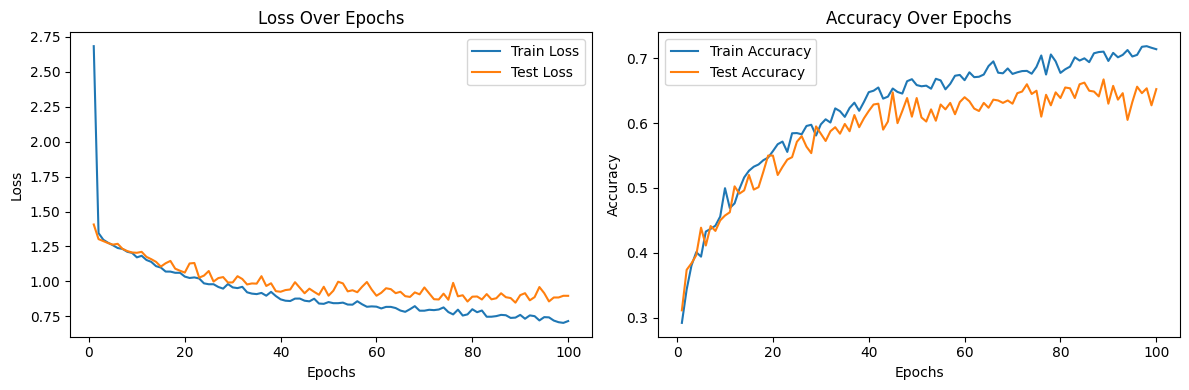

Accuracy finale : 0.6525


In [5]:
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score

#Apprentissage avec Adam avec 100 épochs pour voir les résultats
device = torch.device('cuda')

num_epochs = 100
model = LeNet(num_classes=4)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3) #optimizer différents

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    all_preds = []
    all_labels=[]
    for i, batch in enumerate(tqdm(trainloader,desc=f'Epoch {epoch+1}/{num_epochs}')):
        inputs, label = batch
        inputs, label = inputs.to(device).float(), label.to(device)

        #Apprentissage
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, label)

        running_loss += loss.item()
        #Calcul de l'accuracy
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())
        loss.backward()
        optimizer.step()

    # Stockez la perte d'entraînement moyenne à cette époque
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(accuracy_score(all_labels, all_preds))

    # Calculez la perte de test à cette époque
    running_loss = 0.0
    all_preds = []
    all_labels=[]
    model.train()
    with torch.no_grad():
        for i, batch in enumerate(testloader):
            inputs, label = batch
            inputs, label = inputs.to(device).float(), label.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, label)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    # Stockez la perte de test moyenne à cette époque
    test_losses.append(running_loss / len(testloader))
    test_accuracies.append(accuracy_score(all_labels, all_preds))
    print(f"Accuracy de train : {train_accuracies[-1]}")
    print(f"Accuracy de test : {test_accuracies[-1]}")
    print(f"Loss de train : {train_losses[-1]}")
    print(f"Loss de test : {test_losses[-1]}")
print('Entraînement terminé')


#Affichage des résultats
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()


print(f"Accuracy finale : {test_accuracies[-1]}")

In [6]:
torch.save(model.state_dict(), "lenet.pth")

In [21]:
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.network = nn.Sequential(

            nn.Conv2d(1, 96, kernel_size=11, stride=4),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding='same'), #Padding à same pour avoir la bonne taille
            #nn.Dropout(0.2), #En commentaire pour éviter le surplus de régularisation
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding='same'),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(384),
            nn.ReLU(),

            nn.Conv2d(384, 384, kernel_size=3, padding='same'),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(384),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, padding='same'),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Flatten(),

            nn.Linear(256 * 6 *6, 4096),
            nn.Dropout(0.5),
            nn.ReLU(),

            nn.Linear(4096, 4096),
            nn.Dropout(0.5),

            nn.ReLU(),
            
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        return self.network(x)

In [22]:
#Création des datasets de tests et d'entrainement
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

train_dataset =Data.Subset(df, range(train_size))
test_dataset = Data.Subset(df, range(train_size, train_size + test_size))

trainloader = Data.DataLoader(train_dataset, batch_size=128, shuffle=True)
testloader = Data.DataLoader(test_dataset, batch_size=128, shuffle=False)


Epoch 1/50: 100%|██████████| 25/25 [00:07<00:00,  3.46it/s]


Accuracy de train : 0.32375
Accuracy de test : 0.31625


Epoch 2/50: 100%|██████████| 25/25 [00:07<00:00,  3.44it/s]


Accuracy de train : 0.458125
Accuracy de test : 0.4825


Epoch 3/50: 100%|██████████| 25/25 [00:07<00:00,  3.44it/s]


Accuracy de train : 0.56875
Accuracy de test : 0.56125


Epoch 4/50: 100%|██████████| 25/25 [00:07<00:00,  3.42it/s]


Accuracy de train : 0.615625
Accuracy de test : 0.56


Epoch 5/50: 100%|██████████| 25/25 [00:07<00:00,  3.39it/s]


Accuracy de train : 0.6203125
Accuracy de test : 0.54875


Epoch 6/50: 100%|██████████| 25/25 [00:07<00:00,  3.39it/s]


Accuracy de train : 0.643125
Accuracy de test : 0.63375


Epoch 7/50: 100%|██████████| 25/25 [00:07<00:00,  3.39it/s]


Accuracy de train : 0.6753125
Accuracy de test : 0.61125


Epoch 8/50: 100%|██████████| 25/25 [00:07<00:00,  3.37it/s]


Accuracy de train : 0.69375
Accuracy de test : 0.605


Epoch 9/50: 100%|██████████| 25/25 [00:07<00:00,  3.39it/s]


Accuracy de train : 0.691875
Accuracy de test : 0.65


Epoch 10/50: 100%|██████████| 25/25 [00:07<00:00,  3.37it/s]


Accuracy de train : 0.6996875
Accuracy de test : 0.62125


Epoch 11/50: 100%|██████████| 25/25 [00:07<00:00,  3.38it/s]


Accuracy de train : 0.72625
Accuracy de test : 0.60875


Epoch 12/50: 100%|██████████| 25/25 [00:07<00:00,  3.38it/s]


Accuracy de train : 0.7534375
Accuracy de test : 0.70625


Epoch 13/50: 100%|██████████| 25/25 [00:07<00:00,  3.37it/s]


Accuracy de train : 0.75
Accuracy de test : 0.6375


Epoch 14/50: 100%|██████████| 25/25 [00:07<00:00,  3.36it/s]


Accuracy de train : 0.7553125
Accuracy de test : 0.61625


Epoch 15/50: 100%|██████████| 25/25 [00:07<00:00,  3.35it/s]


Accuracy de train : 0.7659375
Accuracy de test : 0.7425


Epoch 16/50: 100%|██████████| 25/25 [00:07<00:00,  3.36it/s]


Accuracy de train : 0.7846875
Accuracy de test : 0.7275


Epoch 17/50: 100%|██████████| 25/25 [00:07<00:00,  3.35it/s]


Accuracy de train : 0.7965625
Accuracy de test : 0.69875


Epoch 18/50: 100%|██████████| 25/25 [00:07<00:00,  3.37it/s]


Accuracy de train : 0.798125
Accuracy de test : 0.655


Epoch 19/50: 100%|██████████| 25/25 [00:07<00:00,  3.37it/s]


Accuracy de train : 0.8103125
Accuracy de test : 0.57125


Epoch 20/50: 100%|██████████| 25/25 [00:07<00:00,  3.36it/s]


Accuracy de train : 0.8090625
Accuracy de test : 0.62625


Epoch 21/50: 100%|██████████| 25/25 [00:07<00:00,  3.36it/s]


Accuracy de train : 0.813125
Accuracy de test : 0.69875


Epoch 22/50: 100%|██████████| 25/25 [00:07<00:00,  3.37it/s]


Accuracy de train : 0.826875
Accuracy de test : 0.65875


Epoch 23/50: 100%|██████████| 25/25 [00:07<00:00,  3.35it/s]


Accuracy de train : 0.8428125
Accuracy de test : 0.695


Epoch 24/50: 100%|██████████| 25/25 [00:07<00:00,  3.36it/s]


Accuracy de train : 0.8425
Accuracy de test : 0.53


Epoch 25/50: 100%|██████████| 25/25 [00:07<00:00,  3.36it/s]


Accuracy de train : 0.8403125
Accuracy de test : 0.7425


Epoch 26/50: 100%|██████████| 25/25 [00:07<00:00,  3.35it/s]


Accuracy de train : 0.8609375
Accuracy de test : 0.705


Epoch 27/50: 100%|██████████| 25/25 [00:07<00:00,  3.35it/s]


Accuracy de train : 0.8709375
Accuracy de test : 0.705


Epoch 28/50: 100%|██████████| 25/25 [00:07<00:00,  3.36it/s]


Accuracy de train : 0.8646875
Accuracy de test : 0.6775


Epoch 29/50: 100%|██████████| 25/25 [00:07<00:00,  3.34it/s]


Accuracy de train : 0.87375
Accuracy de test : 0.735


Epoch 30/50: 100%|██████████| 25/25 [00:07<00:00,  3.36it/s]


Accuracy de train : 0.86875
Accuracy de test : 0.73875


Epoch 31/50: 100%|██████████| 25/25 [00:07<00:00,  3.37it/s]


Accuracy de train : 0.8975
Accuracy de test : 0.66875


Epoch 32/50: 100%|██████████| 25/25 [00:07<00:00,  3.37it/s]


Accuracy de train : 0.8909375
Accuracy de test : 0.7475


Epoch 33/50: 100%|██████████| 25/25 [00:07<00:00,  3.37it/s]


Accuracy de train : 0.8821875
Accuracy de test : 0.59875


Epoch 34/50: 100%|██████████| 25/25 [00:07<00:00,  3.37it/s]


Accuracy de train : 0.883125
Accuracy de test : 0.6525


Epoch 35/50: 100%|██████████| 25/25 [00:07<00:00,  3.37it/s]


Accuracy de train : 0.87875
Accuracy de test : 0.7575


Epoch 36/50: 100%|██████████| 25/25 [00:07<00:00,  3.36it/s]


Accuracy de train : 0.8915625
Accuracy de test : 0.67875


Epoch 37/50: 100%|██████████| 25/25 [00:07<00:00,  3.34it/s]


Accuracy de train : 0.89875
Accuracy de test : 0.7675


Epoch 38/50: 100%|██████████| 25/25 [00:07<00:00,  3.36it/s]


Accuracy de train : 0.915
Accuracy de test : 0.72125


Epoch 39/50: 100%|██████████| 25/25 [00:07<00:00,  3.36it/s]


Accuracy de train : 0.9159375
Accuracy de test : 0.62875


Epoch 40/50: 100%|██████████| 25/25 [00:07<00:00,  3.37it/s]


Accuracy de train : 0.9096875
Accuracy de test : 0.67125


Epoch 41/50: 100%|██████████| 25/25 [00:07<00:00,  3.37it/s]


Accuracy de train : 0.9140625
Accuracy de test : 0.76875


Epoch 42/50: 100%|██████████| 25/25 [00:07<00:00,  3.36it/s]


Accuracy de train : 0.9040625
Accuracy de test : 0.725


Epoch 43/50: 100%|██████████| 25/25 [00:07<00:00,  3.37it/s]


Accuracy de train : 0.9240625
Accuracy de test : 0.63625


Epoch 44/50: 100%|██████████| 25/25 [00:07<00:00,  3.37it/s]


Accuracy de train : 0.928125
Accuracy de test : 0.625


Epoch 45/50: 100%|██████████| 25/25 [00:07<00:00,  3.36it/s]


Accuracy de train : 0.9175
Accuracy de test : 0.675


Epoch 46/50: 100%|██████████| 25/25 [00:07<00:00,  3.35it/s]


Accuracy de train : 0.8971875
Accuracy de test : 0.765


Epoch 47/50: 100%|██████████| 25/25 [00:07<00:00,  3.36it/s]


Accuracy de train : 0.92375
Accuracy de test : 0.7475


Epoch 48/50: 100%|██████████| 25/25 [00:07<00:00,  3.36it/s]


Accuracy de train : 0.9409375
Accuracy de test : 0.7675


Epoch 49/50: 100%|██████████| 25/25 [00:07<00:00,  3.37it/s]


Accuracy de train : 0.9425
Accuracy de test : 0.745


Epoch 50/50: 100%|██████████| 25/25 [00:07<00:00,  3.36it/s]


Accuracy de train : 0.92875
Accuracy de test : 0.77375
Entraînement terminé


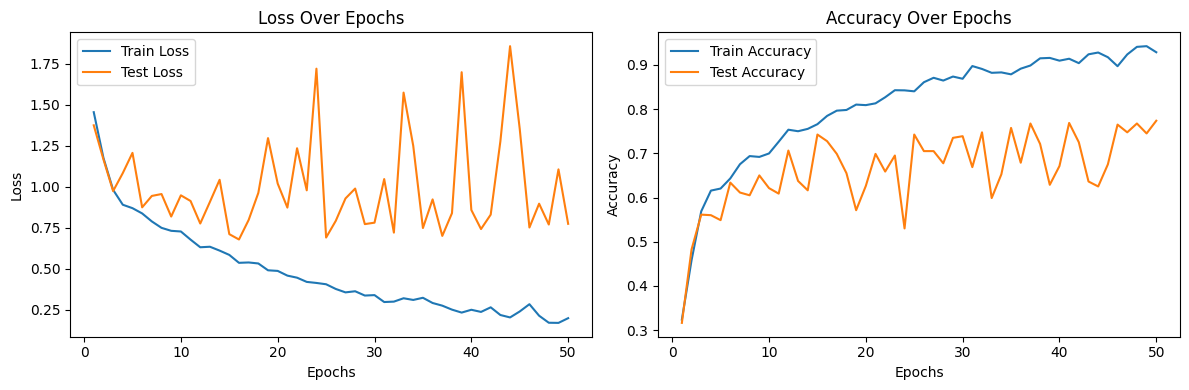

Accuracy finale : 0.77375


In [23]:
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score


device = torch.device('cuda')

num_epochs = 50
model = AlexNet(num_classes=4)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-3)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    all_preds = []
    all_labels=[]
    model.train()
    for i, batch in enumerate(tqdm(trainloader,desc=f'Epoch {epoch+1}/{num_epochs}')):
        inputs, label = batch
        inputs, label = inputs.to(device).float(), label.to(device)

        #Apprentissage
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, label)

        running_loss += loss.item()
        #Calcul de l'accuracy
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())
        loss.backward()
        optimizer.step()

    # Stockez la perte d'entraînement moyenne à cette époque
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(accuracy_score(all_labels, all_preds))

    # Calculez la perte de test à cette époque
    running_loss = 0.0
    all_preds = []
    all_labels=[]

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(testloader):
            inputs, label = batch
            inputs, label = inputs.to(device).float(), label.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, label)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    # Stockez la perte de test moyenne à cette époque
    test_losses.append(running_loss / len(testloader))
    test_accuracies.append(accuracy_score(all_labels, all_preds))
    print(f"Accuracy de train : {train_accuracies[-1]}")
    print(f"Accuracy de test : {test_accuracies[-1]}")
print('Entraînement terminé')


#Affichage des résultats
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()


print(f"Accuracy finale : {test_accuracies[-1]}")

In [19]:
torch.save(model.state_dict(), 'Alex_Net_100_avec_reg.pth') #pour enregistrer le modèle

Epoch 1/150: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Accuracy de train : 0.3115


Epoch 2/150: 100%|██████████| 32/32 [00:11<00:00,  2.88it/s]


Accuracy de train : 0.39625


Epoch 3/150: 100%|██████████| 32/32 [00:10<00:00,  2.92it/s]


Accuracy de train : 0.4465


Epoch 4/150: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


Accuracy de train : 0.5005


Epoch 5/150: 100%|██████████| 32/32 [00:10<00:00,  3.00it/s]


Accuracy de train : 0.53375


Epoch 6/150: 100%|██████████| 32/32 [00:10<00:00,  3.01it/s]


Accuracy de train : 0.54575


Epoch 7/150: 100%|██████████| 32/32 [00:10<00:00,  3.12it/s]


Accuracy de train : 0.567


Epoch 8/150: 100%|██████████| 32/32 [00:10<00:00,  2.92it/s]


Accuracy de train : 0.5975


Epoch 9/150: 100%|██████████| 32/32 [00:10<00:00,  3.13it/s]


Accuracy de train : 0.59225


Epoch 10/150: 100%|██████████| 32/32 [00:10<00:00,  3.02it/s]


Accuracy de train : 0.5925


Epoch 11/150: 100%|██████████| 32/32 [00:10<00:00,  2.91it/s]


Accuracy de train : 0.60625


Epoch 12/150: 100%|██████████| 32/32 [00:10<00:00,  3.07it/s]


Accuracy de train : 0.63075


Epoch 13/150: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]


Accuracy de train : 0.63075


Epoch 14/150: 100%|██████████| 32/32 [00:10<00:00,  3.14it/s]


Accuracy de train : 0.635


Epoch 15/150: 100%|██████████| 32/32 [00:10<00:00,  2.97it/s]


Accuracy de train : 0.63625


Epoch 16/150: 100%|██████████| 32/32 [00:10<00:00,  2.91it/s]


Accuracy de train : 0.6765


Epoch 17/150: 100%|██████████| 32/32 [00:10<00:00,  3.17it/s]


Accuracy de train : 0.69475


Epoch 18/150: 100%|██████████| 32/32 [00:09<00:00,  3.25it/s]


Accuracy de train : 0.69375


Epoch 19/150: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


Accuracy de train : 0.70875


Epoch 20/150: 100%|██████████| 32/32 [00:10<00:00,  3.01it/s]


Accuracy de train : 0.712


Epoch 21/150: 100%|██████████| 32/32 [00:10<00:00,  2.97it/s]


Accuracy de train : 0.707


Epoch 22/150: 100%|██████████| 32/32 [00:10<00:00,  3.01it/s]


Accuracy de train : 0.7295


Epoch 23/150: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]


Accuracy de train : 0.731


Epoch 24/150: 100%|██████████| 32/32 [00:10<00:00,  3.19it/s]


Accuracy de train : 0.74425


Epoch 25/150: 100%|██████████| 32/32 [00:10<00:00,  3.09it/s]


Accuracy de train : 0.743


Epoch 26/150: 100%|██████████| 32/32 [00:11<00:00,  2.87it/s]


Accuracy de train : 0.73925


Epoch 27/150: 100%|██████████| 32/32 [00:09<00:00,  3.27it/s]


Accuracy de train : 0.76225


Epoch 28/150: 100%|██████████| 32/32 [00:09<00:00,  3.23it/s]


Accuracy de train : 0.74125


Epoch 29/150: 100%|██████████| 32/32 [00:10<00:00,  3.20it/s]


Accuracy de train : 0.76475


Epoch 30/150: 100%|██████████| 32/32 [00:10<00:00,  3.12it/s]


Accuracy de train : 0.7505


Epoch 31/150: 100%|██████████| 32/32 [00:10<00:00,  3.13it/s]


Accuracy de train : 0.77025


Epoch 32/150: 100%|██████████| 32/32 [00:09<00:00,  3.21it/s]


Accuracy de train : 0.77175


Epoch 33/150: 100%|██████████| 32/32 [00:10<00:00,  3.02it/s]


Accuracy de train : 0.7605


Epoch 34/150: 100%|██████████| 32/32 [00:09<00:00,  3.41it/s]


Accuracy de train : 0.77075


Epoch 35/150: 100%|██████████| 32/32 [00:10<00:00,  2.93it/s]


Accuracy de train : 0.772


Epoch 36/150: 100%|██████████| 32/32 [00:10<00:00,  2.91it/s]


Accuracy de train : 0.779


Epoch 37/150: 100%|██████████| 32/32 [00:09<00:00,  3.36it/s]


Accuracy de train : 0.77425


Epoch 38/150: 100%|██████████| 32/32 [00:10<00:00,  3.14it/s]


Accuracy de train : 0.77475


Epoch 39/150: 100%|██████████| 32/32 [00:09<00:00,  3.39it/s]


Accuracy de train : 0.77075


Epoch 40/150: 100%|██████████| 32/32 [00:11<00:00,  2.90it/s]


Accuracy de train : 0.791


Epoch 41/150: 100%|██████████| 32/32 [00:10<00:00,  3.09it/s]


Accuracy de train : 0.7585


Epoch 42/150: 100%|██████████| 32/32 [00:09<00:00,  3.33it/s]


Accuracy de train : 0.793


Epoch 43/150: 100%|██████████| 32/32 [00:09<00:00,  3.28it/s]


Accuracy de train : 0.753


Epoch 44/150: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s]


Accuracy de train : 0.7885


Epoch 45/150: 100%|██████████| 32/32 [00:09<00:00,  3.31it/s]


Accuracy de train : 0.8035


Epoch 46/150: 100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


Accuracy de train : 0.8055


Epoch 47/150: 100%|██████████| 32/32 [00:10<00:00,  3.16it/s]


Accuracy de train : 0.79925


Epoch 48/150: 100%|██████████| 32/32 [00:10<00:00,  3.10it/s]


Accuracy de train : 0.80625


Epoch 49/150: 100%|██████████| 32/32 [00:10<00:00,  3.15it/s]


Accuracy de train : 0.81375


Epoch 50/150: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]


Accuracy de train : 0.80225


Epoch 51/150: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


Accuracy de train : 0.8015


Epoch 52/150: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]


Accuracy de train : 0.80275


Epoch 53/150: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


Accuracy de train : 0.8015


Epoch 54/150: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


Accuracy de train : 0.79725


Epoch 55/150: 100%|██████████| 32/32 [00:14<00:00,  2.13it/s]


Accuracy de train : 0.81575


Epoch 56/150: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


Accuracy de train : 0.80775


Epoch 57/150: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


Accuracy de train : 0.8165


Epoch 58/150: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


Accuracy de train : 0.79325


Epoch 59/150: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]


Accuracy de train : 0.80425


Epoch 60/150: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]


Accuracy de train : 0.81425


Epoch 61/150: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]


Accuracy de train : 0.81975


Epoch 62/150: 100%|██████████| 32/32 [00:18<00:00,  1.74it/s]


Accuracy de train : 0.82075


Epoch 63/150: 100%|██████████| 32/32 [00:22<00:00,  1.42it/s]


Accuracy de train : 0.807


Epoch 64/150: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]


Accuracy de train : 0.81325


Epoch 65/150: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]


Accuracy de train : 0.815


Epoch 66/150: 100%|██████████| 32/32 [00:18<00:00,  1.69it/s]


Accuracy de train : 0.815


Epoch 67/150: 100%|██████████| 32/32 [00:22<00:00,  1.41it/s]


Accuracy de train : 0.824


Epoch 68/150: 100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


Accuracy de train : 0.81675


Epoch 69/150: 100%|██████████| 32/32 [00:21<00:00,  1.49it/s]


Accuracy de train : 0.81325


Epoch 70/150: 100%|██████████| 32/32 [00:53<00:00,  1.67s/it]


Accuracy de train : 0.82275


Epoch 71/150: 100%|██████████| 32/32 [01:17<00:00,  2.42s/it]


Accuracy de train : 0.83675


Epoch 72/150: 100%|██████████| 32/32 [01:17<00:00,  2.42s/it]


Accuracy de train : 0.832


Epoch 73/150: 100%|██████████| 32/32 [01:17<00:00,  2.43s/it]


Accuracy de train : 0.836


Epoch 74/150: 100%|██████████| 32/32 [01:17<00:00,  2.43s/it]


Accuracy de train : 0.81325


Epoch 75/150: 100%|██████████| 32/32 [01:17<00:00,  2.43s/it]


Accuracy de train : 0.8315


Epoch 76/150: 100%|██████████| 32/32 [01:17<00:00,  2.42s/it]


Accuracy de train : 0.835


Epoch 77/150: 100%|██████████| 32/32 [01:17<00:00,  2.43s/it]


Accuracy de train : 0.8375


Epoch 78/150: 100%|██████████| 32/32 [01:17<00:00,  2.43s/it]


Accuracy de train : 0.83475


Epoch 79/150: 100%|██████████| 32/32 [01:17<00:00,  2.43s/it]


Accuracy de train : 0.827


Epoch 80/150: 100%|██████████| 32/32 [01:17<00:00,  2.43s/it]


Accuracy de train : 0.82825


Epoch 81/150: 100%|██████████| 32/32 [01:17<00:00,  2.44s/it]


Accuracy de train : 0.8265


Epoch 82/150: 100%|██████████| 32/32 [01:17<00:00,  2.44s/it]


Accuracy de train : 0.8325


Epoch 83/150: 100%|██████████| 32/32 [01:18<00:00,  2.44s/it]


Accuracy de train : 0.833


Epoch 84/150: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]


Accuracy de train : 0.8485


Epoch 85/150: 100%|██████████| 32/32 [00:10<00:00,  3.05it/s]


Accuracy de train : 0.8265


Epoch 86/150: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s]


Accuracy de train : 0.8385


Epoch 87/150: 100%|██████████| 32/32 [00:10<00:00,  2.97it/s]


Accuracy de train : 0.84025


Epoch 88/150: 100%|██████████| 32/32 [00:09<00:00,  3.29it/s]


Accuracy de train : 0.8335


Epoch 89/150: 100%|██████████| 32/32 [00:10<00:00,  3.17it/s]


Accuracy de train : 0.83775


Epoch 90/150: 100%|██████████| 32/32 [00:09<00:00,  3.39it/s]


Accuracy de train : 0.8335


Epoch 91/150: 100%|██████████| 32/32 [00:09<00:00,  3.26it/s]


Accuracy de train : 0.8495


Epoch 92/150: 100%|██████████| 32/32 [00:10<00:00,  3.04it/s]


Accuracy de train : 0.847


Epoch 93/150: 100%|██████████| 32/32 [00:09<00:00,  3.36it/s]


Accuracy de train : 0.84975


Epoch 94/150: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]


Accuracy de train : 0.84


Epoch 95/150: 100%|██████████| 32/32 [00:09<00:00,  3.33it/s]


Accuracy de train : 0.85175


Epoch 96/150: 100%|██████████| 32/32 [00:09<00:00,  3.41it/s]


Accuracy de train : 0.839


Epoch 97/150: 100%|██████████| 32/32 [00:09<00:00,  3.29it/s]


Accuracy de train : 0.85225


Epoch 98/150: 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


Accuracy de train : 0.8445


Epoch 99/150: 100%|██████████| 32/32 [00:09<00:00,  3.39it/s]


Accuracy de train : 0.8395


Epoch 100/150: 100%|██████████| 32/32 [00:09<00:00,  3.26it/s]


Accuracy de train : 0.839


Epoch 101/150: 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


Accuracy de train : 0.84275


Epoch 102/150: 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


Accuracy de train : 0.83525


Epoch 103/150: 100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


Accuracy de train : 0.85625


Epoch 104/150: 100%|██████████| 32/32 [00:09<00:00,  3.32it/s]


Accuracy de train : 0.8635


Epoch 105/150: 100%|██████████| 32/32 [00:10<00:00,  2.95it/s]


Accuracy de train : 0.854


Epoch 106/150: 100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Accuracy de train : 0.8565


Epoch 107/150: 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


Accuracy de train : 0.84925


Epoch 108/150: 100%|██████████| 32/32 [00:10<00:00,  3.14it/s]


Accuracy de train : 0.8595


Epoch 109/150: 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


Accuracy de train : 0.86825


Epoch 110/150: 100%|██████████| 32/32 [00:10<00:00,  3.11it/s]


Accuracy de train : 0.85575


Epoch 111/150: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]


Accuracy de train : 0.872


Epoch 112/150: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]


Accuracy de train : 0.8695


Epoch 113/150: 100%|██████████| 32/32 [00:09<00:00,  3.30it/s]


Accuracy de train : 0.8595


Epoch 114/150: 100%|██████████| 32/32 [00:09<00:00,  3.38it/s]


Accuracy de train : 0.8625


Epoch 115/150: 100%|██████████| 32/32 [00:09<00:00,  3.21it/s]


Accuracy de train : 0.86025


Epoch 116/150: 100%|██████████| 32/32 [00:10<00:00,  2.95it/s]


Accuracy de train : 0.86575


Epoch 117/150: 100%|██████████| 32/32 [00:10<00:00,  3.16it/s]


Accuracy de train : 0.8655


Epoch 118/150: 100%|██████████| 32/32 [00:09<00:00,  3.41it/s]


Accuracy de train : 0.861


Epoch 119/150: 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


Accuracy de train : 0.8685


Epoch 120/150: 100%|██████████| 32/32 [00:10<00:00,  3.19it/s]


Accuracy de train : 0.8715


Epoch 121/150: 100%|██████████| 32/32 [00:10<00:00,  3.13it/s]


Accuracy de train : 0.87325


Epoch 122/150: 100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


Accuracy de train : 0.8645


Epoch 123/150: 100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


Accuracy de train : 0.869


Epoch 124/150: 100%|██████████| 32/32 [00:09<00:00,  3.42it/s]


Accuracy de train : 0.87325


Epoch 125/150: 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


Accuracy de train : 0.8655


Epoch 126/150: 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


Accuracy de train : 0.865


Epoch 127/150: 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


Accuracy de train : 0.87225


Epoch 128/150: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]


Accuracy de train : 0.88425


Epoch 129/150: 100%|██████████| 32/32 [00:10<00:00,  3.04it/s]


Accuracy de train : 0.8665


Epoch 130/150: 100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


Accuracy de train : 0.86625


Epoch 131/150: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]


Accuracy de train : 0.87825


Epoch 132/150: 100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


Accuracy de train : 0.87175


Epoch 133/150: 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


Accuracy de train : 0.87075


Epoch 134/150: 100%|██████████| 32/32 [00:09<00:00,  3.34it/s]


Accuracy de train : 0.8795


Epoch 135/150: 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


Accuracy de train : 0.8795


Epoch 136/150: 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


Accuracy de train : 0.87325


Epoch 137/150: 100%|██████████| 32/32 [00:10<00:00,  3.19it/s]


Accuracy de train : 0.86675


Epoch 138/150: 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


Accuracy de train : 0.86925


Epoch 139/150: 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


Accuracy de train : 0.884


Epoch 140/150: 100%|██████████| 32/32 [00:09<00:00,  3.33it/s]


Accuracy de train : 0.88775


Epoch 141/150: 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


Accuracy de train : 0.88925


Epoch 142/150: 100%|██████████| 32/32 [00:09<00:00,  3.29it/s]


Accuracy de train : 0.8815


Epoch 143/150: 100%|██████████| 32/32 [00:10<00:00,  3.08it/s]


Accuracy de train : 0.88


Epoch 144/150: 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


Accuracy de train : 0.888


Epoch 145/150: 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


Accuracy de train : 0.886


Epoch 146/150: 100%|██████████| 32/32 [00:10<00:00,  3.04it/s]


Accuracy de train : 0.8705


Epoch 147/150: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]


Accuracy de train : 0.88575


Epoch 148/150: 100%|██████████| 32/32 [00:09<00:00,  3.36it/s]


Accuracy de train : 0.89525


Epoch 149/150: 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


Accuracy de train : 0.87225


Epoch 150/150: 100%|██████████| 32/32 [00:09<00:00,  3.29it/s]

Accuracy de train : 0.87975
Entraînement terminé


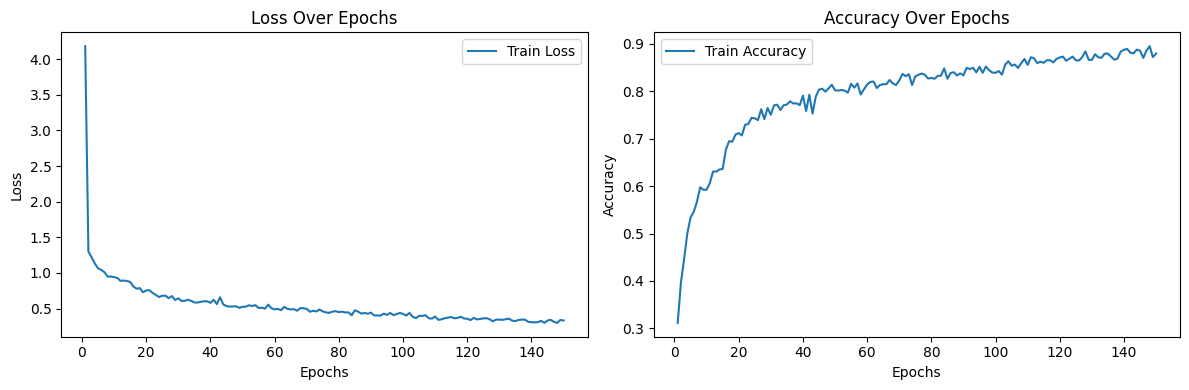

Accuracy finale : 0.87975


In [37]:
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score

trainloader = Data.DataLoader(df, batch_size=128, shuffle=True)

device = torch.device('cuda')

#On fait maintenant un entrainement sur toutes les données de train avec les paramètres optimaux trouver précédemment
num_epochs = 150
model = AlexNet(num_classes=4)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-3)

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    all_preds = []
    all_labels=[]
    model.train()
    for i, batch in enumerate(tqdm(trainloader,desc=f'Epoch {epoch+1}/{num_epochs}')):
        inputs, label = batch
        inputs, label = inputs.to(device).float(), label.to(device)

        #Apprentissage
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, label)

        running_loss += loss.item()
        #Calcul de l'accuracy
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())
        loss.backward()
        optimizer.step()

    # Stockez la perte d'entraînement moyenne à cette époque
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(accuracy_score(all_labels, all_preds))
    print(f"Accuracy de train : {train_accuracies[-1]}")


    

    
print('Entraînement terminé')

#Affichage des résulats
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()


print(f"Accuracy finale : {train_accuracies[-1]}")
torch.save(model.state_dict(), 'Alex_Net_150_train.pth')

In [8]:
import torch.nn.functional as F
#Code pour créer le .csv à mettre sur Kaggle
y_pred = []
idx = range(4000,5082)
device = torch.device('cuda')

#Création du jeu de données
test_set=ImageDataset("train.csv","test/test",test=True)
test_loader=Data.DataLoader(test_set,batch_size=1,shuffle=False)

dossier = "test/test/"
#Chargement du modèles
model=LeNet(num_classes=4)
model.load_state_dict(torch.load('lenet.pth'))
model.to(device)


model.eval()
# Prédiction sur chacune des images
with torch.no_grad():
    for img in test_loader:
        img=img.to(device)
        y = model(img)
        y = F.softmax(y,dim=1)
        y_argmax = torch.argmax(y).item()
        y_pred.append((y_argmax +1))

#Conversion en dataframe pandas
df = pd.DataFrame({'id': idx, 'pred': y_pred})
#Enregistrement au format csv
df.to_csv('lenet.csv',header=True,index=False)
        

/home/tristan/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
